# Email Spam Classifier

In [54]:
import pandas as pd
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

## Load and preprocess the data 

In [13]:
df = pd.read_csv('data/completeSpamAssassin.csv')

In [14]:
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [15]:
# Drop unnecessary column
df = df.drop('Unnamed: 0', axis=1)
df['Body'] = df['Body'].astype(str)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    6046 non-null   object
 1   Label   6046 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 94.6+ KB


In [17]:
def stemmer(text):
    if isinstance(text, str):  # Ensure text is a string
        stemmer = PorterStemmer()
        return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text):
    if isinstance(text, str):  # Ensure text is a string
        lemmatizer = WordNetLemmatizer()
        return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    return text

In [18]:
# apply both stemming and lemmatizing to df
df['Body'] = df['Body'].apply(stemmer).apply(lemmatizer)
df

,Body,Label
0,save up to 70 % on life insur . whi spend more...,1
1,1 ) fight the risk of cancer ! http : //www.ad...,1
2,1 ) fight the risk of cancer ! http : //www.ad...,1
3,# # # # # # # # # # # # # # # # # # # # # # # ...,1
4,I thought you might like these : 1 ) slim down...,1
...,...,...
6041,empti,0
6042,___ ___ ___ /\ \ /\ \ /\ \ ___ | : : \ \ \ : \...,0
6043,IN thi issue:01 . reader write 02 . extens sea...,0
6044,empti,0


In [40]:
X = df.drop('Label', axis = 1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X['Body'], y, random_state = 41)

## Model selection/training
I experimented with 3 different types of models - Logistic Regression, Naive Bayes, and Decision Trees GridSearchCV - and 2 types of vectorizers - Tfidf vectorizer and Count vectorizer. I used GridSearchCV for each combination to identify the best overall model and its best parameters. 

Also, I passed the scoring='f1' argument to each GridSearchCV object to provide a balance between precision and recall.

In [41]:
tfidf_params = {'tfidf__max_features': [100, 500, 1000, 2000, 5000, None], 'tfidf__stop_words': ['english', None]}

cvect_params = {'cvect__max_features': [100, 500, 1000, 2000, 5000, None], 'cvect__stop_words': ['english', None]}

In [42]:
tfidf_lgr_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('lgr', LogisticRegression(max_iter=100000))])
tfidf_lgr_grid = GridSearchCV(tfidf_lgr_pipe, param_grid = tfidf_params, scoring='f1').fit(X_train, y_train)
tfidf_lgr_test_acc = tfidf_lgr_grid.score(X_test, y_test)


In [57]:
print(tfidf_lgr_test_acc)
print(tfidf_lgr_grid.best_params_)

0.9211873080859775
{'tfidf__max_features': 2000, 'tfidf__stop_words': None}


In [44]:
cvect_lgr_pipe = Pipeline([('cvect', CountVectorizer()), ('lgr', LogisticRegression(max_iter=100000))])
cvect_lgr_grid = GridSearchCV(cvect_lgr_pipe, param_grid = cvect_params, scoring='f1').fit(X_train, y_train)
cvect_lgr_test_acc = cvect_lgr_grid.score(X_test, y_test)

In [58]:
print(cvect_lgr_test_acc)
print(cvect_lgr_grid.best_params_)

0.9257028112449799
{'cvect__max_features': 5000, 'cvect__stop_words': 'english'}


In [46]:
tfidf_dtree_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('dtree', DecisionTreeClassifier())])
tfidf_dtree_grid = GridSearchCV(tfidf_dtree_pipe, param_grid = tfidf_params, scoring='f1').fit(X_train, y_train)
tfidf_dtree_test_acc = tfidf_dtree_grid.score(X_test, y_test)

In [59]:
print(tfidf_dtree_test_acc)
print(tfidf_dtree_grid.best_params_)

0.8679245283018868
{'tfidf__max_features': 5000, 'tfidf__stop_words': None}


In [48]:
cvect_dtree_pipe = Pipeline([('cvect', CountVectorizer()), ('dtree', DecisionTreeClassifier())])
cvect_dtree_grid = GridSearchCV(cvect_dtree_pipe, param_grid = cvect_params, scoring='f1').fit(X_train, y_train)
cvect_dtree_test_acc = cvect_dtree_grid.score(X_test, y_test)

In [49]:
print(cvect_dtree_test_acc)
print(cvect_dtree_grid.best_params_)

0.8776541961577351
{'cvect__max_features': None, 'cvect__stop_words': 'english'}


In [50]:
tfidf_bayes_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('bayes', MultinomialNB())])
tfidf_bayes_grid = GridSearchCV(tfidf_bayes_pipe, param_grid = tfidf_params, scoring='f1').fit(X_train, y_train)
tfidf_bayes_test_acc = tfidf_bayes_grid.score(X_test, y_test)

In [51]:
print(tfidf_bayes_test_acc)
print(tfidf_bayes_grid.best_params_)

0.915736040609137
{'tfidf__max_features': 2000, 'tfidf__stop_words': None}


In [52]:
cvect_bayes_pipe = Pipeline([('cvect', CountVectorizer()), ('dtree', MultinomialNB())])
cvect_bayes_grid = GridSearchCV(cvect_bayes_pipe, param_grid = cvect_params, scoring='f1').fit(X_train, y_train)
cvect_bayes_test_acc = cvect_bayes_grid.score(X_test, y_test)

In [53]:
print(cvect_bayes_test_acc)
print(cvect_bayes_grid.best_params_)

0.9271794871794872
{'cvect__max_features': None, 'cvect__stop_words': None}


After this testing, the MultinomialNB classifier with the Count Vectorizer seems to be the best option.

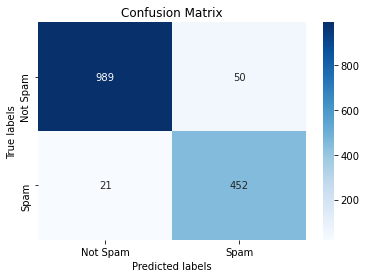

In [60]:
cm = confusion_matrix(y_test, cvect_bayes_grid.predict(X_test))

class_labels = ['Not Spam', 'Spam']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

As seen in the confusion matrix, the model does a good job classifying spam from nonspam. Of the 1010 emails predicted to be not spam, 989 of them were actually not spam. The model predicted 502 emails in the test dataset were spam, and 452 of those were correctly identified as spam.